In [2]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [3]:
sys.path.insert(1, '../../python')
sys.path.insert(1, '../../..')
import util
import plotting
import kde

In [4]:
import matplotlib as mpl

In [5]:
plt.style.use("custom") # custom style sheet
plt.style.use("muted") # muted color theme from SciencePlots
# plt.rcParams['text.usetex'] = False

In [6]:
cm_seq = sns.cubehelix_palette(start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True)
colors = mpl.colors.to_rgba_array(['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1', '#C2E4EF', '#EAECCC', '#FEDA8B', '#FDB366', '#F67E4B', '#DD3D2D', '#A50026'])
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [7]:
from itertools import combinations

# Load data

In [8]:
cv_trajs = list(np.load('../../data/raw_feat/cv_dist_spin_anton.npy', allow_pickle=True))
cv_trajs.extend(np.load('../../data/raw_feat/cv_dist_spin_suppl_00.npy', allow_pickle=True))
cv_trajs.extend(np.load('../../data/raw_feat/cv_dist_spin_suppl_01.npy', allow_pickle=True))
cv_trajs.extend(np.load('../../data/raw_feat/cv_dist_spin_suppl_02.npy', allow_pickle=True))

In [9]:
sb_labels = []
for r in ('R217', 'R223', 'R226', 'R229', 'R232'):
    for n in ('D129', 'D136', 'D151', 'D164', 'E183', 'D186'):
        sb_labels.append(f'{r} - {n}')

In [10]:
sb_trajs = list(np.load('../../data/raw_feat/feat2_raw_anton.npy', allow_pickle=True))
for i in range(6):
    sb_trajs.extend(np.load(f'../../data/raw_feat/feat2_suppl_{i:02d}.npy', allow_pickle=True))

In [11]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3729000, 2) (3729000, 60)


In [12]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

In [13]:
len(traj_files)

244

# Distance basis

In [14]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42] # R226-D129
sb2 = sb_arr[:, 47] # R226-D186
sb3 = sb_arr[:, 48] # R229-D129
sb4 = sb_arr[:, 53] # R229-D186
sb5 = sb_arr[:, 59] # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction) 
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge) 
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = (((dist_ax_down**2 + rot_ax_down**2) < 1)
                & (sb1 > 0.6) & (sb2 < 0.5)).nonzero()[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (((((dist + 0.506) / 0.84)**2 + ((rot - 3.94) / 7.6)**2) < 1)
                & (sb1 < 0.5) & (sb3 < 1.1) 
                  & (sb4 < 0.75) & (sb5 < 0.6)).nonzero()[0]

In [15]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [16]:
assert (len(down_ids) + len(up_ids) + len(other_sbs)) == len(cv_arr)
print(f'Number of down structures:  {len(down_ids)}')
print(f'Number of up structures:   {len(up_ids)}')
print(f'Number of other structures: {len(other_sbs)}')

Number of down structures:  40649
Number of up structures:   6649
Number of other structures: 3681702


## compute distance to states

In [13]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [14]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
        sb_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f'{perc:.2f}% completed')

0.09% completed
0.18% completed
0.27% completed
0.35% completed
0.44% completed
0.53% completed
0.62% completed
0.71% completed
0.80% completed
0.89% completed
0.97% completed
1.06% completed
1.15% completed
1.24% completed
1.33% completed
1.42% completed
1.50% completed
1.59% completed
1.68% completed
1.77% completed
1.86% completed
1.95% completed
2.04% completed
2.12% completed
2.21% completed
2.30% completed
2.39% completed
2.48% completed
2.57% completed
2.66% completed
2.74% completed
2.83% completed
2.92% completed
3.01% completed
3.10% completed
3.19% completed
3.28% completed
3.36% completed
3.45% completed
3.54% completed
3.63% completed
3.72% completed
3.81% completed
3.89% completed
3.98% completed
4.07% completed
4.16% completed
4.25% completed
4.34% completed
4.43% completed
4.51% completed
4.60% completed
4.69% completed
4.78% completed
4.87% completed
4.96% completed
5.05% completed
5.13% completed
5.22% completed
5.31% completed
5.40% completed
5.49% completed
5.58% co

In [15]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1,1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(3729000, 1)


In [16]:
np.save('../../data/feat2_dist_du_suppl_2/dist_down', d_down_arr)

In [17]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
        sb_arr, up[::skip], n_jobs=20, reduce_func=reduce_func):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f'{perc:.2f}% completed')

0.54% completed
1.08% completed
1.62% completed
2.17% completed
2.71% completed
3.25% completed
3.79% completed
4.33% completed
4.87% completed
5.41% completed
5.95% completed
6.50% completed
7.04% completed
7.58% completed
8.12% completed
8.66% completed
9.20% completed
9.74% completed
10.29% completed
10.83% completed
11.37% completed
11.91% completed
12.45% completed
12.99% completed
13.53% completed
14.07% completed
14.62% completed
15.16% completed
15.70% completed
16.24% completed
16.78% completed
17.32% completed
17.86% completed
18.41% completed
18.95% completed
19.49% completed
20.03% completed
20.57% completed
21.11% completed
21.65% completed
22.19% completed
22.74% completed
23.28% completed
23.82% completed
24.36% completed
24.90% completed
25.44% completed
25.98% completed
26.52% completed
27.07% completed
27.61% completed
28.15% completed
28.69% completed
29.23% completed
29.77% completed
30.31% completed
30.86% completed
31.40% completed
31.94% completed
32.48% complete

In [18]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1,1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(3729000, 1)


In [19]:
np.save('../../data/feat2_dist_du_suppl_2/dist_up', d_up_arr)

## Basis and smoothing

In [16]:
# make smoothing function
smooth = (d_down_arr * d_up_arr)**0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr**2) / (d_down_arr**2 + d_up_arr**2)
guess_up = (d_down_arr**2) / (d_down_arr**2 + d_up_arr**2)

# make smoothing 0 at boundaries (down and up states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

NameError: name 'd_down_arr' is not defined

In [21]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(3729000, 1) (3729000, 1) (3729000, 1)


In [17]:
import random
random.seed(123)

In [18]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

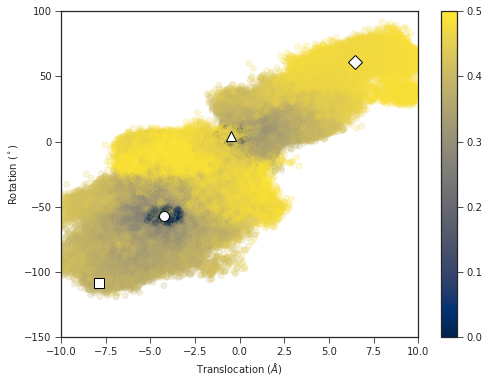

In [25]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap='cividis')
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.)
plotting.format_cvs(ax)

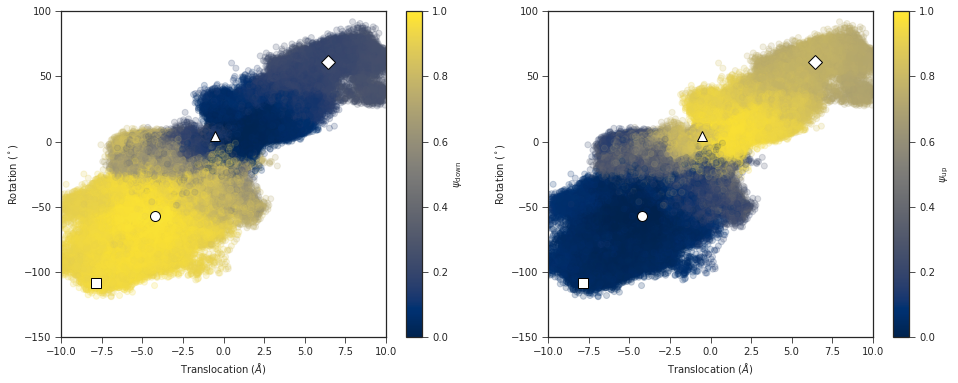

In [26]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
labels = ("$\psi_{\mathrm{down}}$", "$\psi_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2, cmap='cividis')
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.)
    plotting.format_cvs(ax)

# Weights

In [27]:
# cluster IVAC points with K-means
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=sb_arr,
    k=200,
    max_iter=100,
    n_jobs=40
)

08-11-21 14:18:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 19 steps.


In [28]:
dtrajs = km.dtrajs[0]

In [33]:
np.save('../../data/feat2_dist_du_suppl_2/dtrajs_200', dtrajs)

In [19]:
dtrajs = np.load("../../data/feat2_dist_du_suppl_2/dtrajs_200.npy", allow_pickle=True)

In [20]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)

basisL_arr = util.make_sparse_basis(dtrajs)

traj_lens = [len(traj) for traj in cv_trajs]
basisL = []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr:curr + t_len])
    curr += t_len
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(basisL), basisL[0].shape)
print(len(guessU))
print(len(guessD))

NameError: name 'guess_up' is not defined

In [21]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [37]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basisL, lag))

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [71]:
len(weights[0][0])

10000

In [38]:
np.save("../../data/feat2_dist_du_suppl_2/weights", weights, allow_pickle=True)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [19]:
weights = np.load("../../data/feat2_dist_du_suppl_2/weights.npy", allow_pickle=True)

In [20]:
# plot cluster centers
km.cluster_centers_.shape

NameError: name 'km' is not defined

In [21]:
sb_ids = [42, 48, 47, 53]

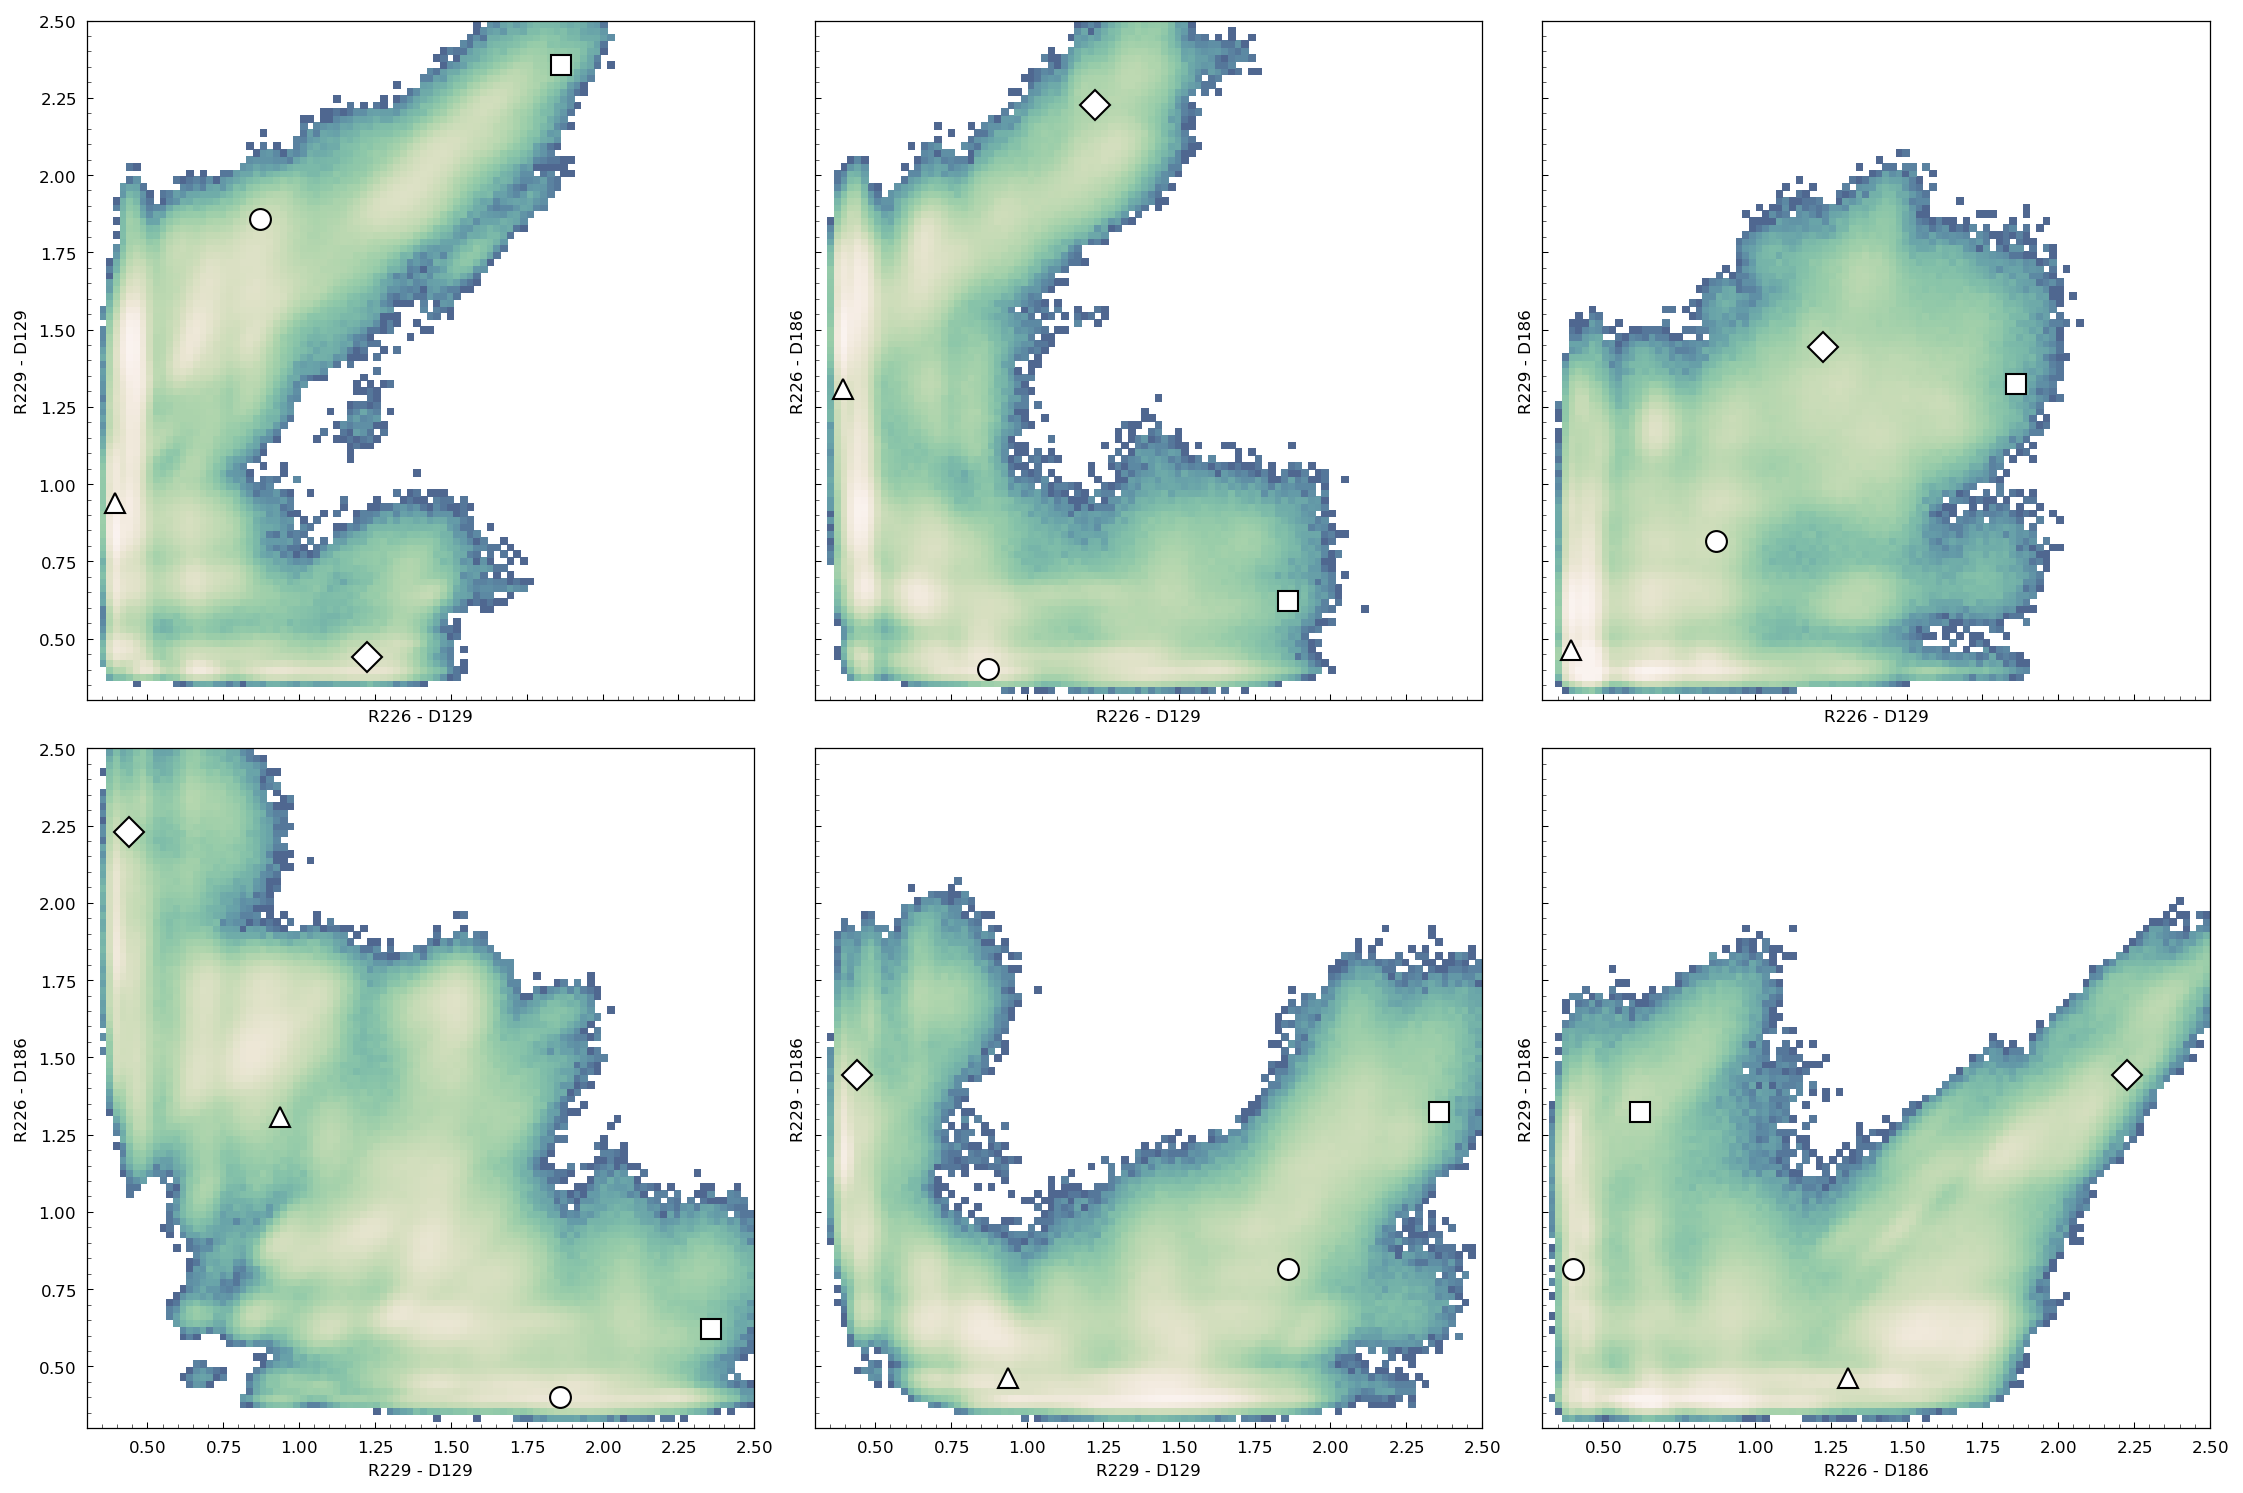

In [22]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

norm = mpl.colors.LogNorm() # log scale
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    _, _, _, h = ax.hist2d(sb_arr[:, sb1], sb_arr[:, sb2], 
              bins=100, 
              range=[[0.3, 2.5], [0.3, 2.5]], 
              cmin=0.001,
              density=True,
              cmap=cm_seq,
              norm=norm
             )
    
    ax.set(xlabel=f"{sb_labels[sb1 - 30]}", ylabel=f"{sb_labels[sb2 - 30]}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#     for (x, y) in km.cluster_centers_[:, [sb1, sb2]]:
#         ax.plot(x, y, 'ko')

axes[0][0].set(xlim=[0.3, 2.5], ylim=[0.3, 2.5])
plotting.plot_sb_models(axes.flat, mode='du', centroids=True)
f.tight_layout()

# Basis

In [56]:
def orthogonalize(basis, pi):
    numer = 0
    for b, p in zip(basis, pi):
        numer += np.einsum("m,mi,mj->ij", p, b, b)
        denom += np.sum(p)
    evals, evecs = scipy.linalg.eigh(numer / denom)
    coeffs = evecs / np.sqrt(evals)[None, :]
    return [b @ coeffs for b in basis]

In [58]:
basis_smooth = smooth * sb_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=0.9999)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(3729000, 60)
(3729000, 59)


Text(0.5, 1.0, 'Smoothed and orthorgonalized basis')

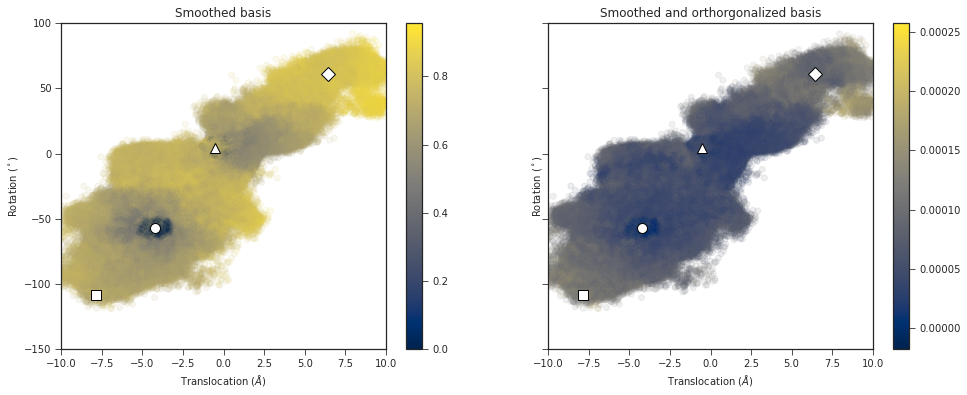

In [59]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
h1 = ax1.scatter(cv_arr[inds, 0], cv_arr[inds, 1], 
                c=np.mean(basis_smooth[inds, :], axis=1), 
                alpha=0.1, 
                cmap='cividis')
h2 = ax2.scatter(cv_arr[inds, 0], cv_arr[inds, 1], 
                c=np.mean(basis_white[inds, :], axis=1), 
                alpha=0.1, 
                cmap='cividis')
for h, ax in zip((h1, h2), (ax1, ax2)):
    plotting.format_cvs(ax)
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
ax1.set_title('Smoothed basis')
ax2.set_title('Smoothed and orthorgonalized basis')

In [60]:
basisF = np.split(basis_white, traj_inds)
print(len(basisF), basisF[0].shape)

480 (10000, 59)


# PMF

In [22]:
# PMFs
dist_trajs = [traj[:,0] for traj in cv_trajs]
rot_trajs = [traj[:,1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [23]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/tmp/jobs/17143759/ipykernel_37891/529077411.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


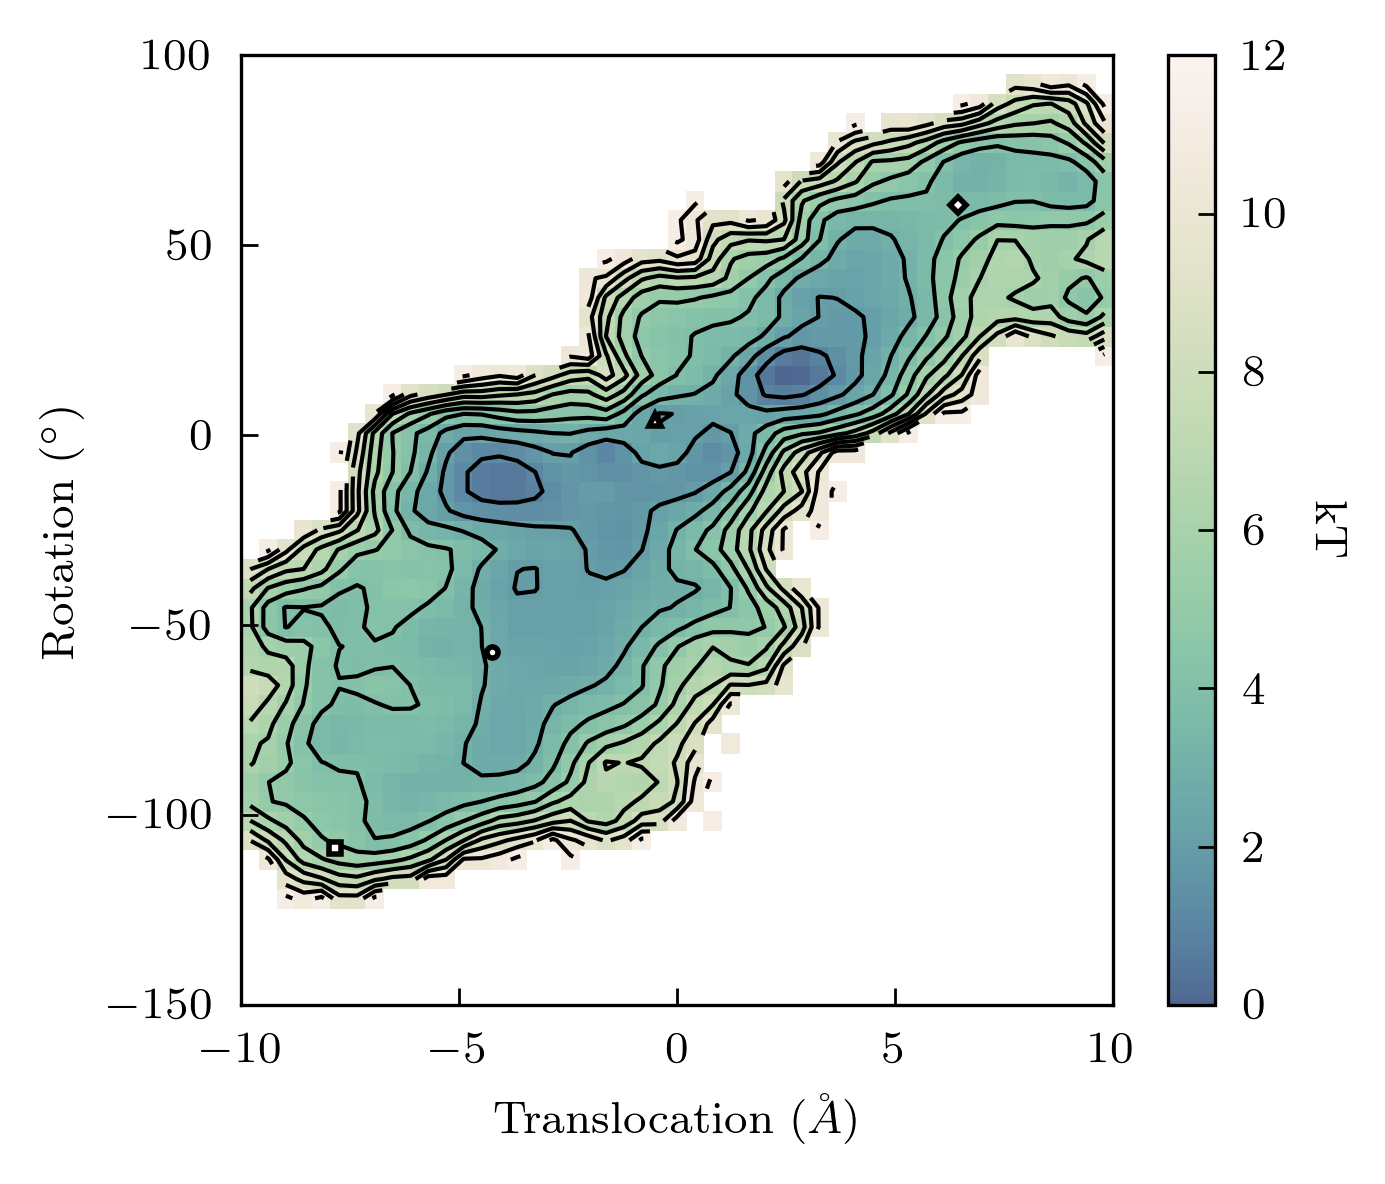

In [24]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3), dpi=400)

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(
    xlim, ylim, diff, 
    cmap=cm_seq, 
    vmax=12, 
    label='kT')
cb = plt.colorbar(h, ax=ax)
cb.set_label("kT", rotation=-90, labelpad=10)
ax.contour(
    centerx, centery, diff, 
    levels=clines, 
    colors='black'
)
# ax.set_title(f'Lag = 0.1 ns')
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

/tmp/jobs/16967478/ipykernel_16556/1519593168.py:7: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


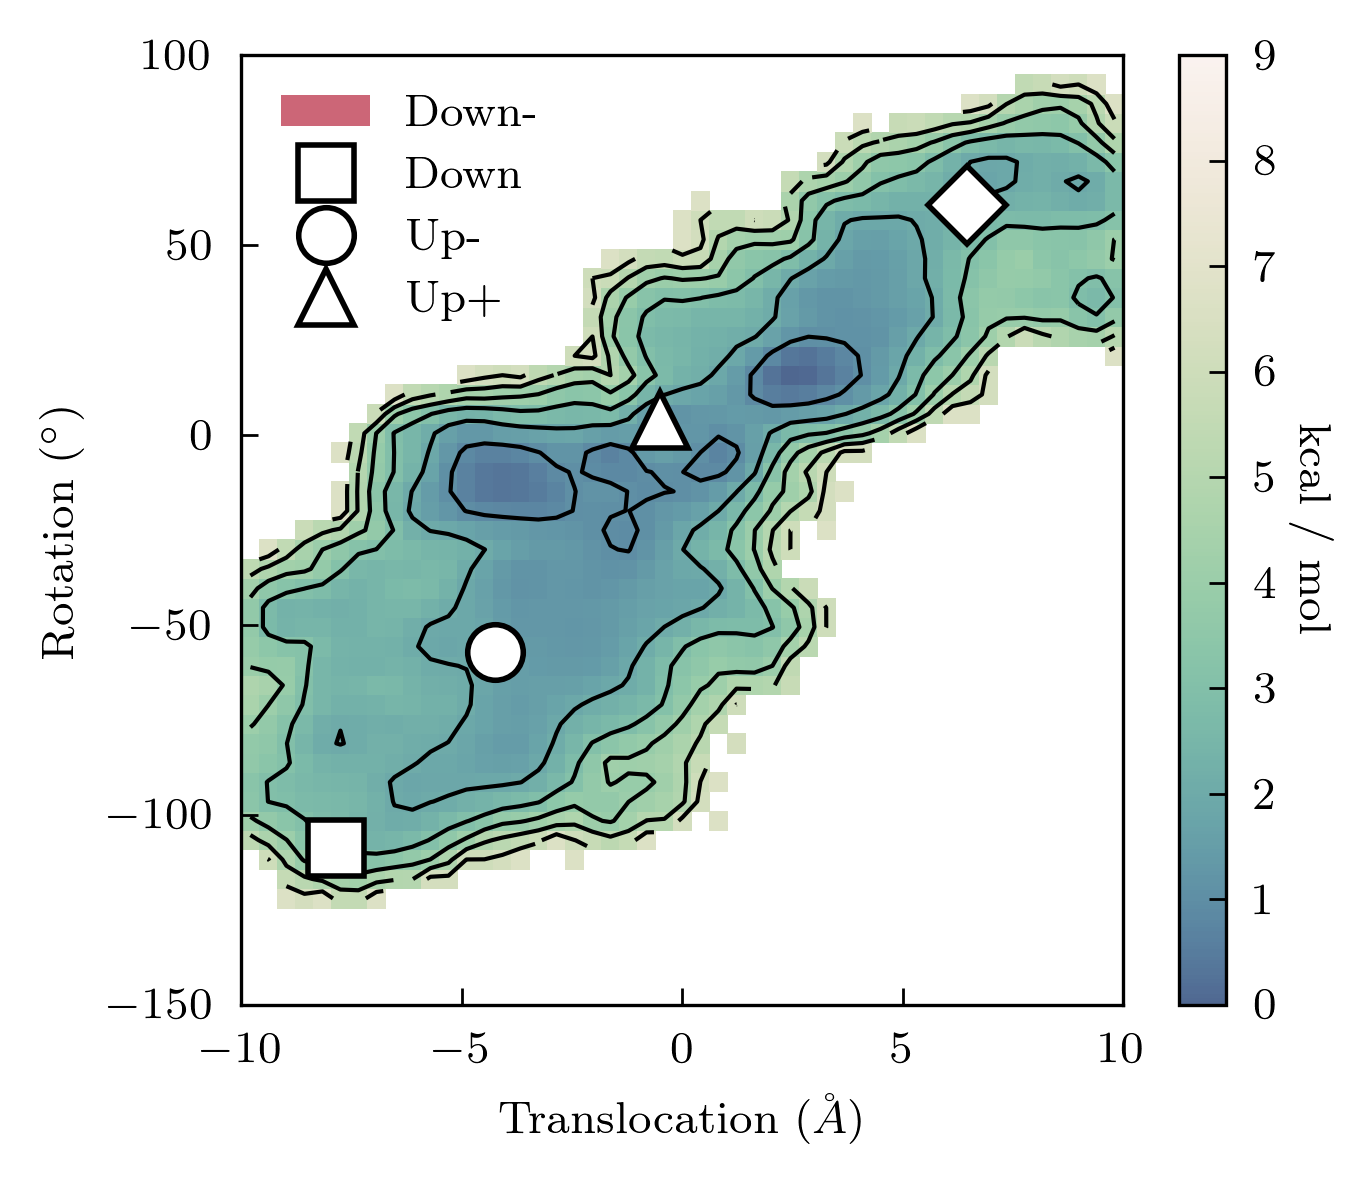

In [30]:
clines = np.linspace(0, 9, 10)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=400)

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(
    xlim, ylim, diff * 0.593, 
    cmap=cm_seq, 
    vmax=9, 
    label='kcal / mol')
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(
    centerx, centery, diff * 0.593, 
    levels=clines, 
    colors='black'
)
# ax.set_title(f'Lag = 0.1 ns')
plotting.format_cvs(ax, centroids=True)
ax.legend(['Down-', 'Down', 'Up-', 'Up+'], loc='upper left')
f.tight_layout()

# Committors

In [25]:
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

NameError: name 'traj_inds' is not defined

In [26]:
len(in_domain)

NameError: name 'in_domain' is not defined

In [66]:
q_downup, qb_downup = [], []
for (lag, com) in zip(lags, weights):
    print(f'Calculating committors for lag {lag}')
    q_downup.append(
        extq.dga.forward_committor(basisF, com, in_domain, guessU, lag)
    )
    qb_downup.append(
        extq.dga.backward_committor(basisF, com, in_domain, guessD, lag)
    )

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100


AssertionError: 

In [27]:
# np.save("../../data/feat2_dist_du_suppl_2/q_downup", q_downup)
# np.save("../../data/feat2_dist_du_suppl_2/qb_downup", qb_downup)
q_downup = np.load("../../data/feat2_dist_du_suppl_2/q_downup.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat2_dist_du_suppl_2/qb_downup.npy", allow_pickle=True)

In [28]:
print(len(q_downup))

6


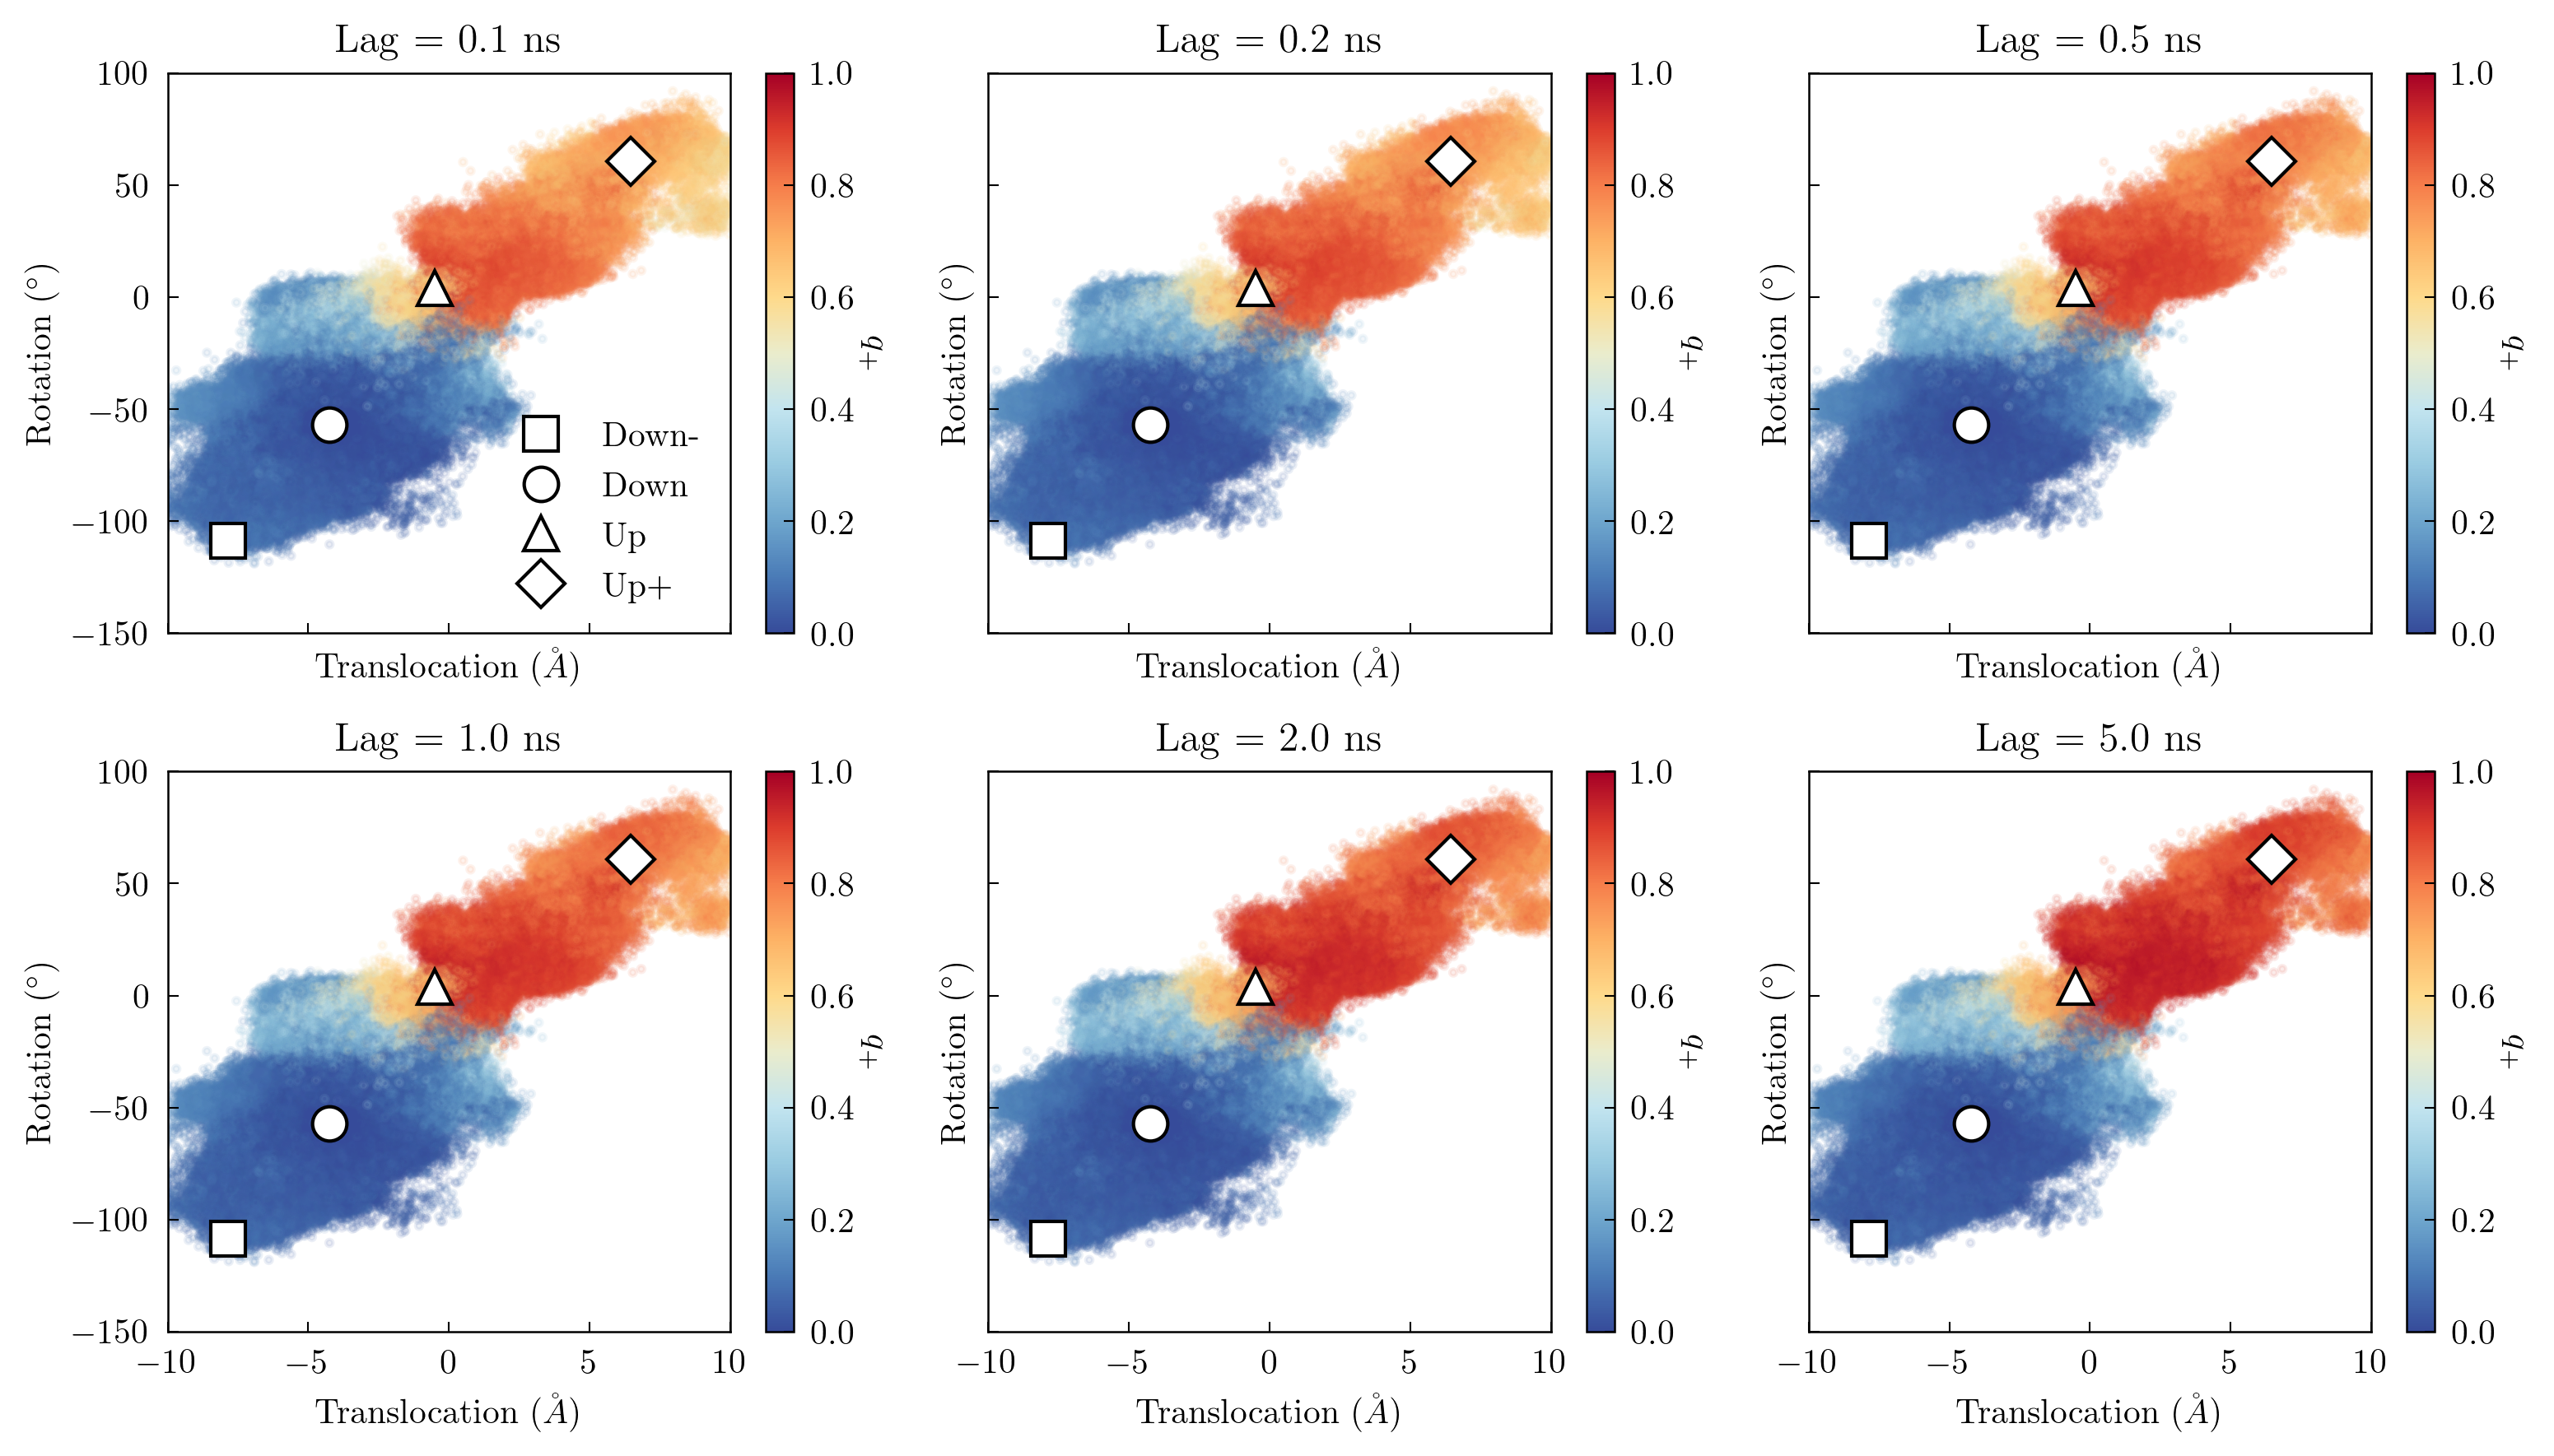

In [51]:
f, axs = plt.subplots(2, 3, figsize=(10.5, 6), sharex=True, sharey=True, dpi=300)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0., max=1.)
    h = ax.scatter(*cv_arr[inds].T, 
                  c=q_arr[inds],
                  cmap=cm_div,
                  alpha=0.1)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f'Lag = {lag * 0.1} ns')
    plotting.format_cvs(ax, centroids=True)
    cbar.set_label('$q_+$', rotation=-90, labelpad=10)

axs.flat[0].legend(['Down-', 'Down', 'Up', "Up+"], loc="lower right")
f.tight_layout()
# plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_ds_alllags", dpi=300)

In [29]:
com = np.concatenate(weights[5])
q_arr = np.concatenate(q_downup[5]).clip(min=0, max=1)
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], 
    cv_arr[:, 1],
    bins=100,
    density=False,
    weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0],
    cv_arr[:, 1],
    bins=100,
    density=False,
    weights=com
)

/tmp/jobs/17143759/ipykernel_37891/1405072897.py:2: RuntimeWarning: invalid value encountered in true_divide
  h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)


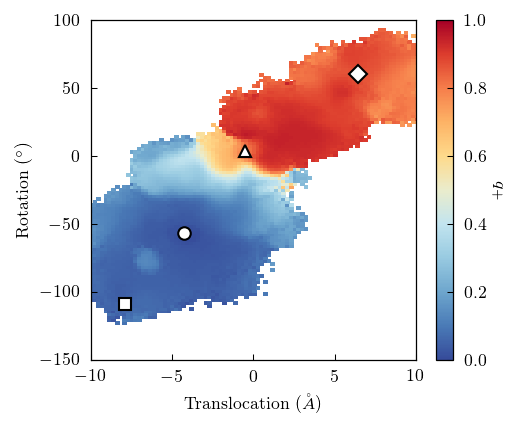

In [30]:
f, ax = plt.subplots(figsize=(3.5, 3))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label('$q_+$', rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)
# plt.xlim([-6, 0])
# plt.ylim([-60, 10])
# plt.title('lag = 5 ns')

In [32]:
com = np.concatenate(weights[5])
q_arr = np.concatenate(qb_downup[5]).clip(min=0, max=1)
q_dens, xe, ye = np.histogram2d(cv_arr[:, 0], 
                        cv_arr[:, 1],
                        bins=100,
                        density=False,
                        weights=q_arr * com
                       )
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0],
    cv_arr[:, 1],
    bins=100,
    density=False,
    weights=com
)

/tmp/jobs/17026201/ipykernel_246967/3492786333.py:2: RuntimeWarning: invalid value encountered in true_divide
  h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)


Text(0.5, 1.0, 'lag = 5 ns')

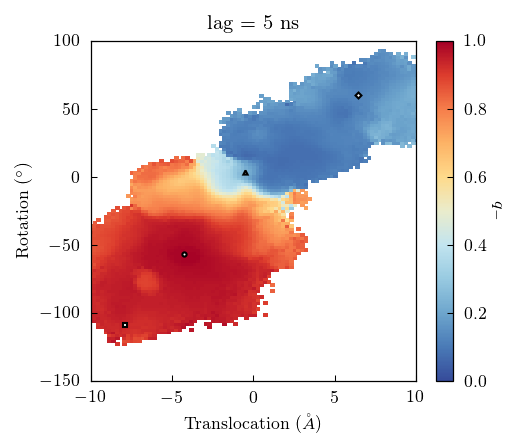

In [33]:
f, ax = plt.subplots(figsize=(3.5, 3))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label('$q_-$', rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True)
plt.title('lag = 5 ns')

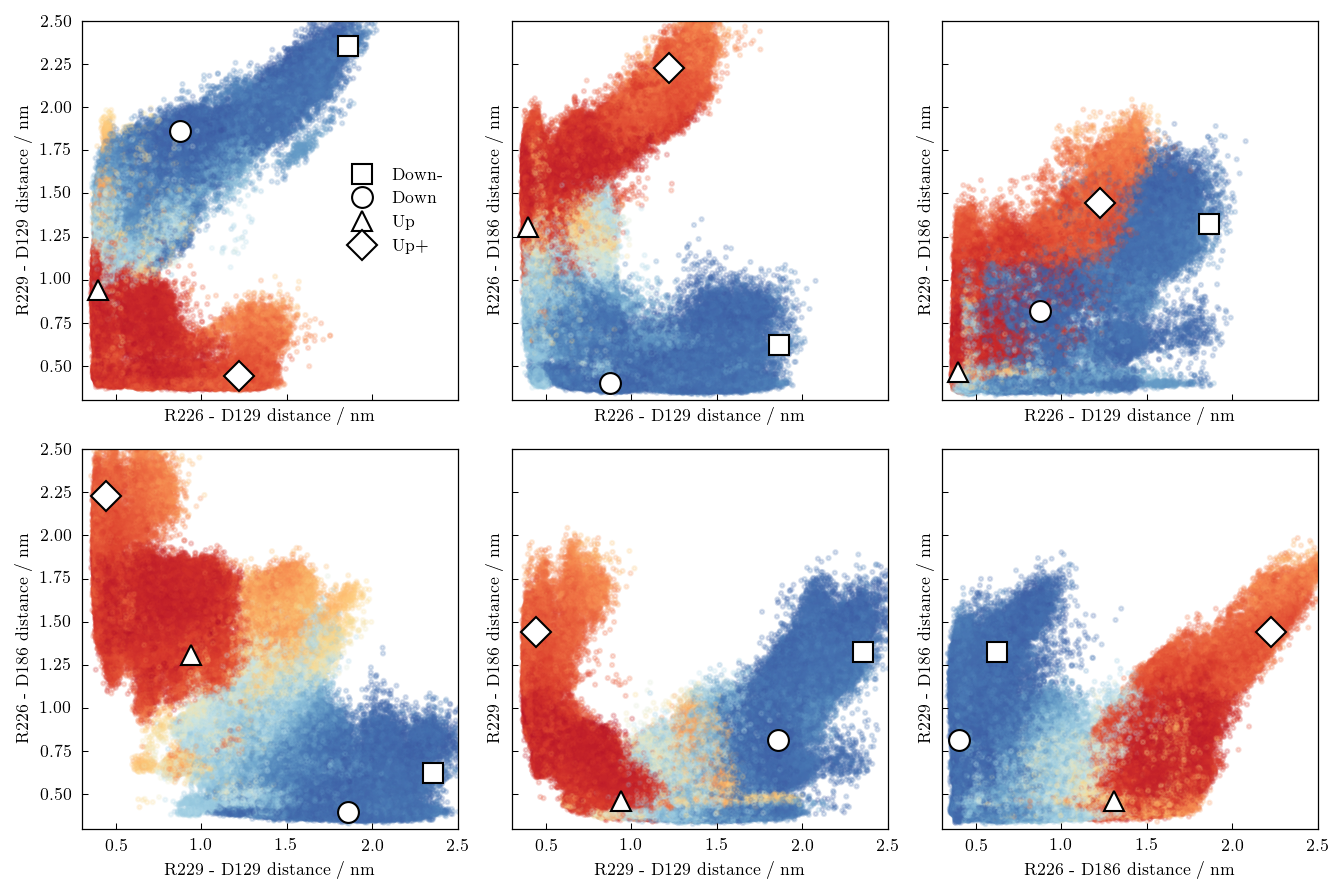

In [31]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

q_arr = np.concatenate(q_downup[5])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(sb_arr[inds, sb1], 
               sb_arr[inds, sb2],
               c=q_arr[inds],
               cmap=cm_div,
               alpha=0.2)
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / nm", 
        ylabel=f"{sb_labels[sb2 - 30]} distance / nm",
        xlim=[0.3, 2.5],
        ylim=[0.3, 2.5]
    )
# cbar = f.colorbar(h, ax=axes.ravel().tolist())
# cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode='du', centroids=True)
axes[0][0].legend(['Down-', 'Down', 'Up', 'Up+'], loc='right')

# plt.suptitle(f"Committor, lag = {lags[5] * 0.1} ns")
f.tight_layout()
plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_sb_5ns.png", dpi=300)

In [34]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

In [35]:
sb_models.shape

(4, 60)

In [36]:
f, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=400)

q_arr = np.concatenate(q_downup[5])
for ((sb1, sb2), ax) in zip(((42, 48), (47, 53)), axes.flat):
    h = ax.scatter(
        sb_arr[inds, sb1] * 10, 
        sb_arr[inds, sb2] * 10,
        c=q_arr[inds],
        cmap=cm_div,
        alpha=0.2)
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / Å", 
        ylabel=f"{sb_labels[sb2 - 30]} distance / Å",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
    cb.set_label('$q_+$', rotation=-90, labelpad=10)
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
print(ax.
axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')    
axes[0].set(xlim=[3, 15], ylim=[8, 20])
axes[1].set(xlim=[3, 15], ylim=[3, 15])

f.tight_layout()

SyntaxError: invalid syntax (856938232.py, line 22)

/tmp/jobs/17026201/ipykernel_246967/2706437226.py:24: RuntimeWarning: invalid value encountered in true_divide
  xe, ye, (q_dens / w_dens).T, cmap=cm_div)


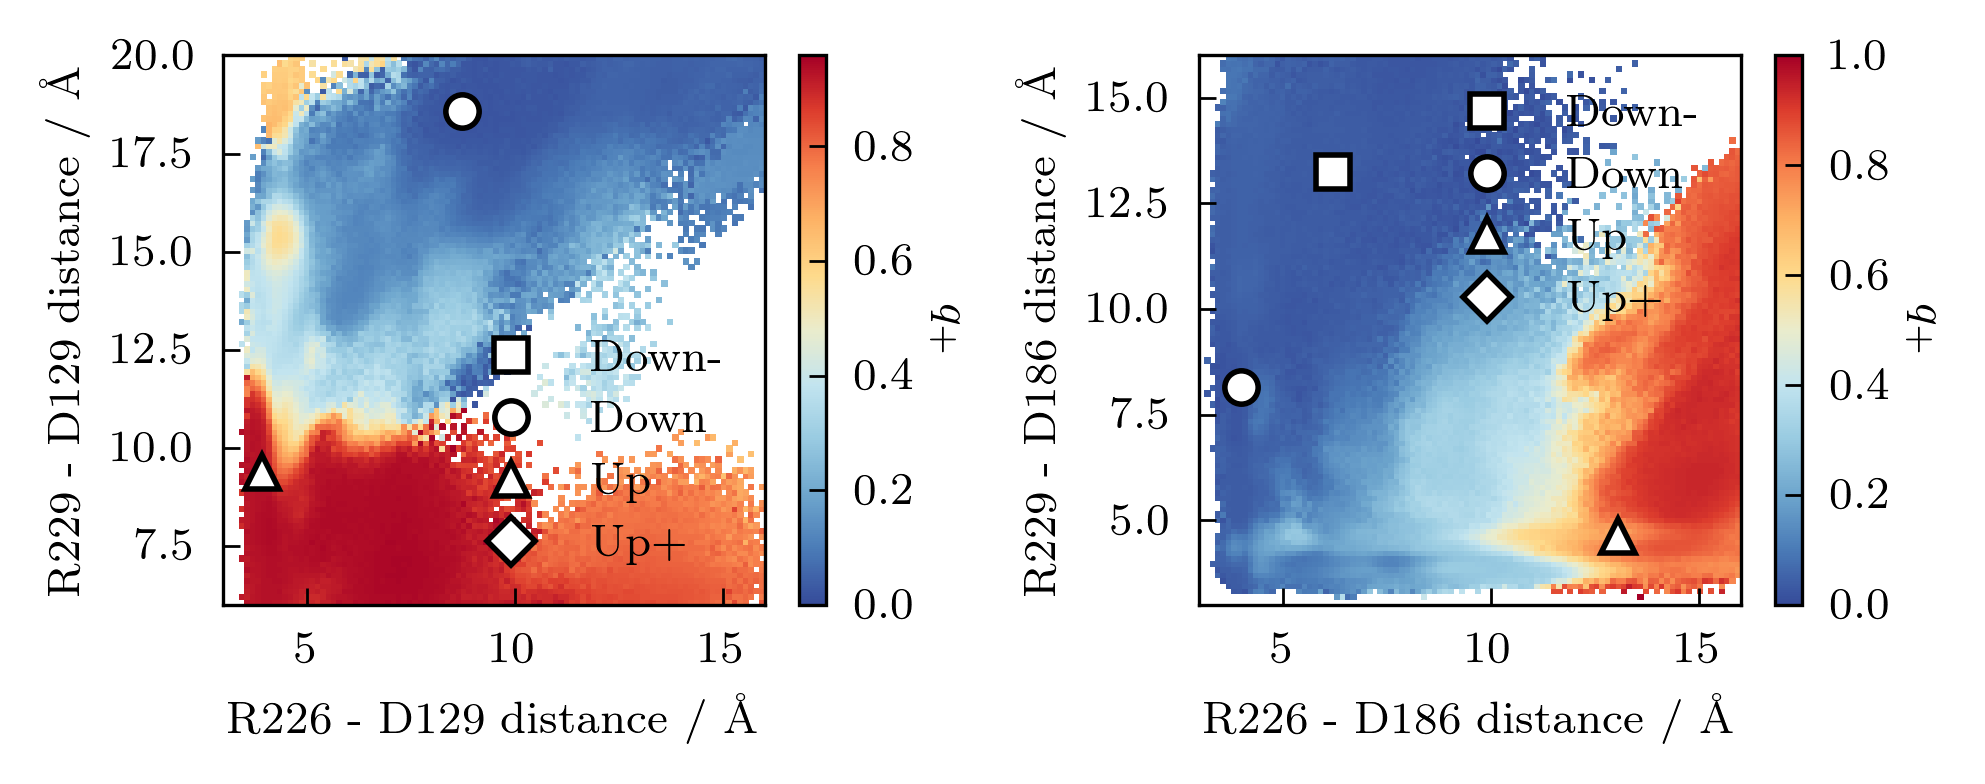

In [37]:
f, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=400)

q_arr = np.concatenate(q_downup[5]).clip(min=0, max=1)
range0 = [[3, 16], [6, 20]]
range1 = [[3, 16], [3, 16]]
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes.flat, (range0, range1)):
    q_dens, xe, ye = np.histogram2d(
        sb_arr[:, sb1] * 10, 
        sb_arr[:, sb2] * 10,
        bins=100,
        density=False,
        range=r,
        weights=q_arr * com
    )
    w_dens, _, _ = np.histogram2d(
        sb_arr[:, sb1] * 10, 
        sb_arr[:, sb2] * 10,
        bins=100,
        density=False,
        range=r,
        weights=com
    )
    h = ax.pcolor(
        xe, ye, (q_dens / w_dens).T, cmap=cm_div)
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / Å", 
        ylabel=f"{sb_labels[sb2 - 30]} distance / Å",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
    cb.set_label('$q_+$', rotation=-90, labelpad=10)
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')    
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

f.tight_layout()

/tmp/jobs/17026201/ipykernel_246967/1792192753.py:24: RuntimeWarning: invalid value encountered in true_divide
  xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)


[(3.0, 16.0), (3.0, 16.0)]

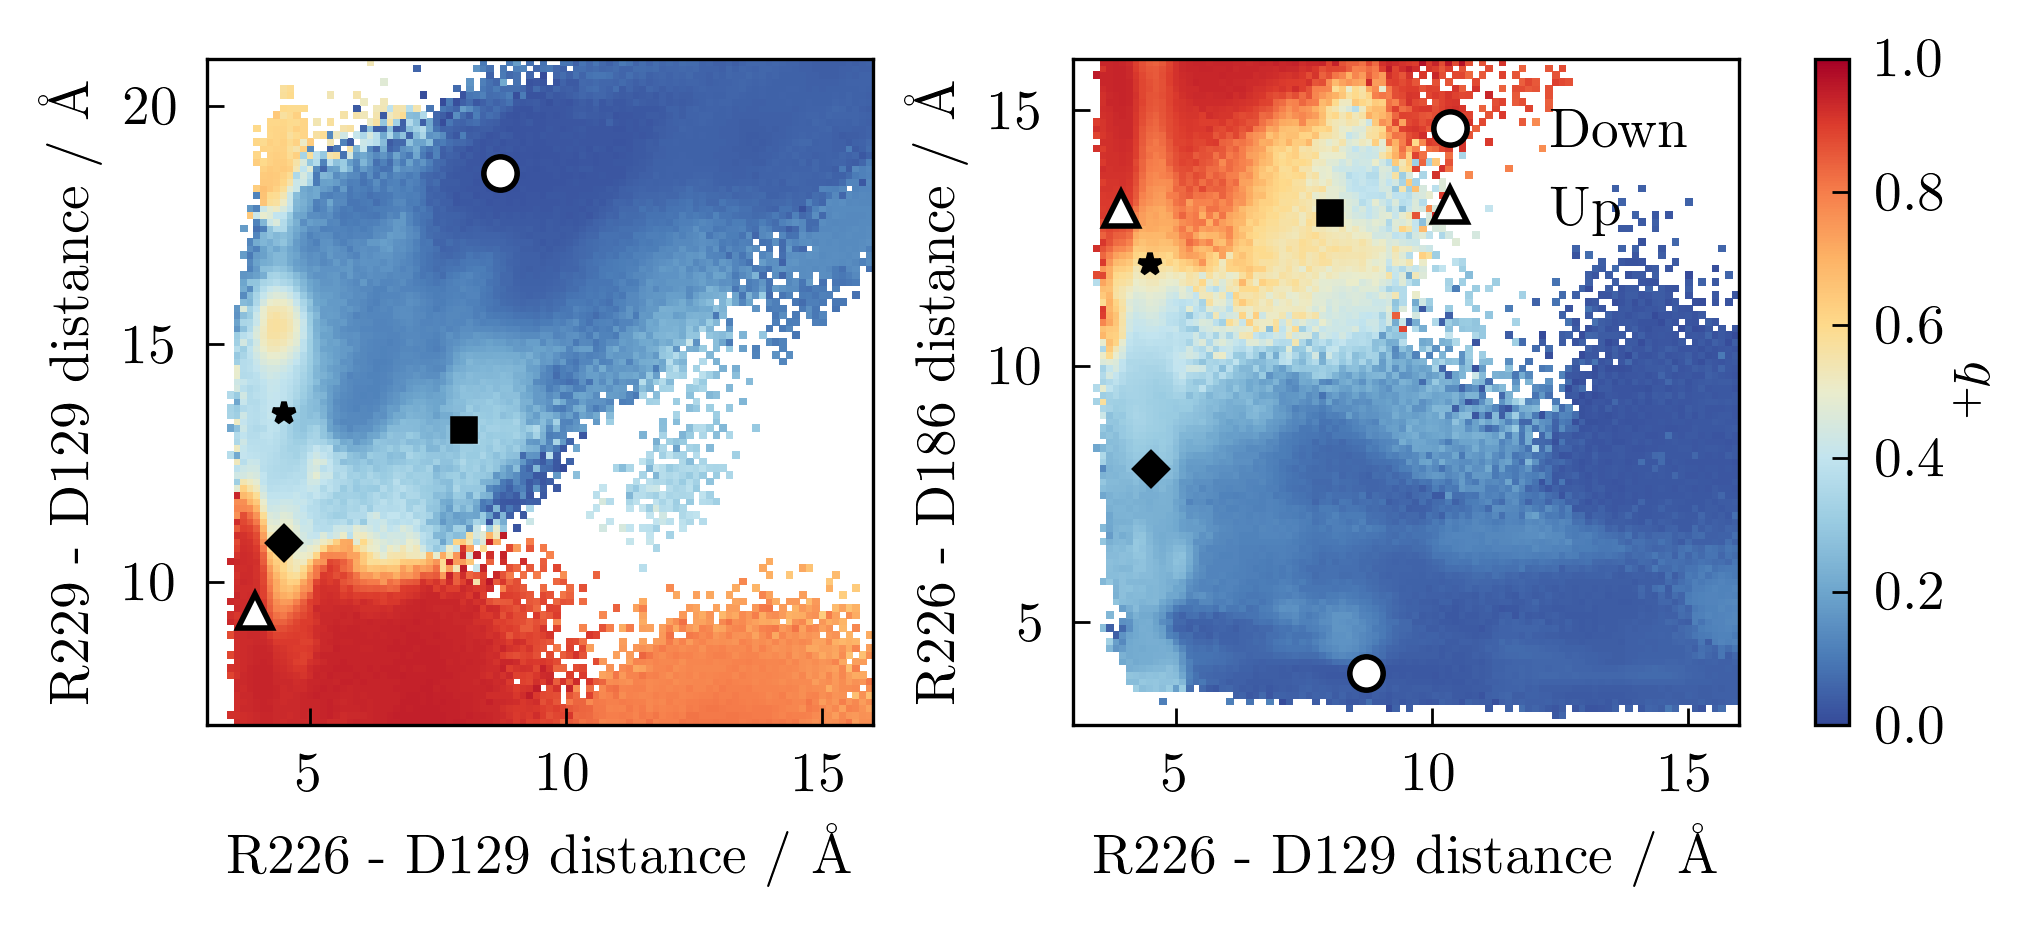

In [54]:
f, axes = plt.subplots(1, 2, figsize=(5, 2.2), dpi=400, constrained_layout=True)

q_arr = np.concatenate(q_downup[5]).clip(min=0, max=1)
range0 = [[3, 16], [7, 21]]
range1 = [[3, 16], [3, 16]]
for ((sb1, sb2), ax, r) in zip(((42, 48), (42, 47)), axes.flat, (range0, range1)):
    q_dens, xe, ye = np.histogram2d(
        sb_arr[:, sb1] * 10, 
        sb_arr[:, sb2] * 10,
        bins=100,
        density=False,
        range=r,
        weights=q_arr * com
    )
    w_dens, _, _ = np.histogram2d(
        sb_arr[:, sb1] * 10, 
        sb_arr[:, sb2] * 10,
        bins=100,
        density=False,
        range=r,
        weights=com
    )
    h = ax.pcolor(
        xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / Å", 
        ylabel=f"{sb_labels[sb2 - 30]} distance / Å",
    )
    # plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
    ax.plot(sb_models[1, sb1] * 10, sb_models[1, sb2] * 10, "o", mfc='w', mec="k", ms=6, label="Down")
    ax.plot(sb_models[2, sb1] * 10, sb_models[2, sb2] * 10, "^", mfc='w', mec="k", ms=6, label="Up")
    
    ax.plot(sb_arr[2917154, sb1] * 10, sb_arr[2917154, sb2] * 10, '*k', ms=4)
    ax.plot(sb_arr[269128, sb1] * 10, sb_arr[269128, sb2] * 10, 'Dk', ms=4)
    ax.plot(sb_arr[3360122, sb1] * 10, sb_arr[3360122, sb2] * 10, 'sk', ms=4)

cb = plt.colorbar(h, ax=axes)
cb.set_label('$q_+$', rotation=-90, labelpad=10)
# plt.legend(bbox_to_anchor=(0.0, -0.1), loc='upper right', frameon='True')
axes[1].legend(loc='upper right')
# axes[1].legend(loc='upper right')
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

# f.tight_layout()

## 3d projections

In [39]:
# %matplotlib widget
%matplotlib inline

In [40]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

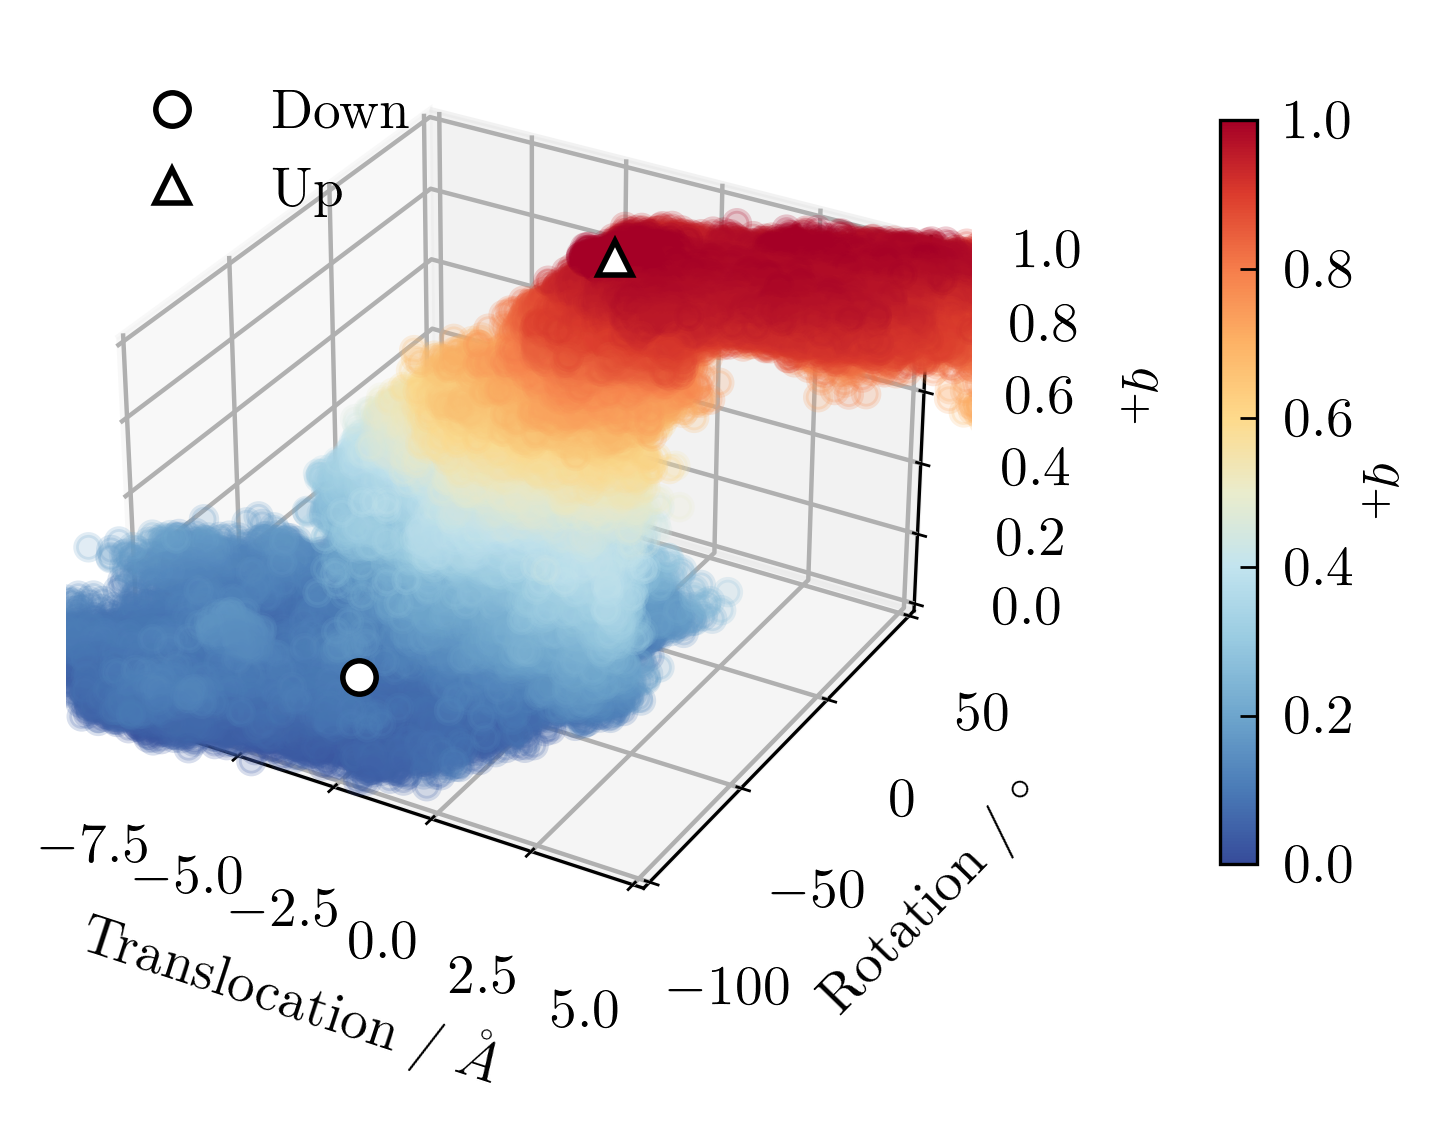

In [41]:
f = plt.figure(figsize=(4, 3), dpi=400)
ax = f.add_subplot(projection='3d')

q = np.concatenate(q_downup[5]).clip(min=0, max=1)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], q[inds], 
           c=q[inds], cmap=cm_div, alpha=0.2)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("$q_+$", rotation=-90)
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.2, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)
cbar.set_label('$q_+$', rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 10 ns lag')

ax.grid(visible=True)
ax.plot(centroids[1, 0], centroids[1, 1], 0, 
        'o', mec='k', mfc='w', ms=6, zorder=5, label="Down")
ax.plot(centroids[2, 0], centroids[2, 1], 1, 
        '^', mec='k', mfc='w', ms=6, zorder=5, label="Up")
ax.legend(loc='upper left')
# plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_dsq_5ns.png", dpi=300)

In [75]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

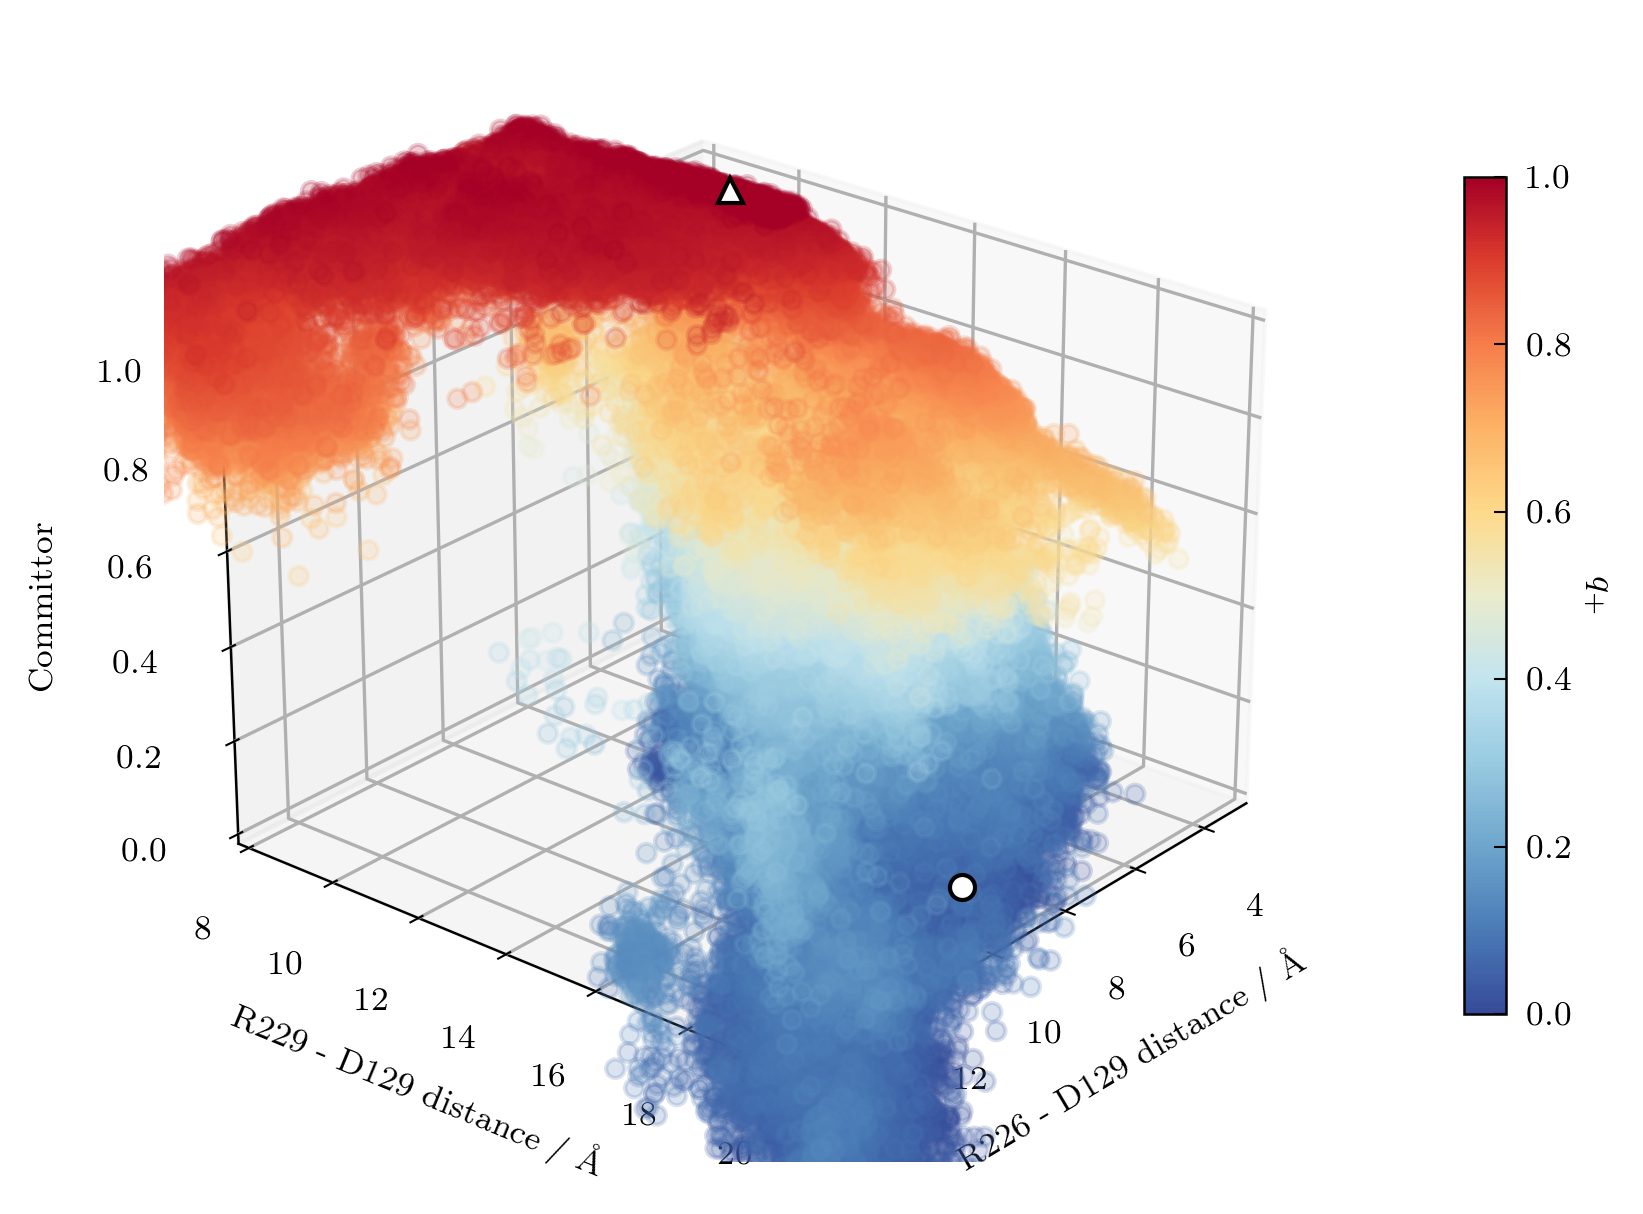

In [80]:
f = plt.figure(figsize=(6, 5), dpi=300)
ax = f.add_subplot(projection='3d')

ax.scatter(sb_arr[inds, sb_ids[0]] * 10, 
    sb_arr[inds, sb_ids[1]] * 10, 
    q[inds], 
    c=q[inds], 
    cmap=cm_div, 
    alpha=0.2)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / Å")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]} distance / Å")
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("Committor", rotation=90)
ax.set_xlim([3, 15])
ax.set_ylim([8, 20])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.12, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)
cbar.set_label('$q_+$', rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

ax.grid(visible=True)
ax.plot(feat2_models[1, sb_ids[0]] * 10, feat2_models[1, sb_ids[1]] * 10, 0, 
        'o', mec='k', mfc='w', ms=6, zorder=3, label="Down")
ax.plot(feat2_models[2, sb_ids[0]] * 10, feat2_models[2, sb_ids[1]] * 10, 1, 
        '^', mec='k', mfc='w', ms=6, zorder=3, label="Up")
# ax.legend(['Down', 'Up'], loc='upper right')

ax.view_init(azim=40, elev=25)
# plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_sb12q_5ns.png", dpi=300)

In [88]:
feat2_models[1, sb_ids[0]] * 10, feat2_models[1, sb_ids[2]] * 10

(8.72528076171875, 4.004758298397064)

In [ ]:
f = plt.figure(figsize=(6, 5), dpi=300)
ax = f.add_subplot(projection='3d')

ax.scatter(sb_arr[inds, sb_ids[0]] * 10, 
    sb_arr[inds, sb_ids[2]] * 10, 
    q[inds], 
    c=q[inds], 
    cmap=cm_div, 
    alpha=0.2)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / Å")
ax.set_ylabel(f"{sb_labels[sb_ids[2] - 30]} distance / Å")
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("Committor", rotation=-90)
ax.set_xlim([3, 15])
ax.set_ylim([3, 15])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.12, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)
cbar.set_label('$q_+$', rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

ax.grid(visible=True)
ax.plot(feat2_models[1, sb_ids[0]] * 10, feat2_models[1, sb_ids[2]] * 10, 0, 
        'o', mec='k', mfc='w', ms=6, zorder=5, label="Down")
ax.plot(feat2_models[2, sb_ids[0]] * 10, feat2_models[2, sb_ids[2]] * 10, 1, 
        '^', mec='k', mfc='w', ms=6, zorder=5, label="Up")
ax.legend(loc='upper left')

# ax.view_init(azim=40, elev=25)
# plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_sb02q_5ns.png", dpi=300)

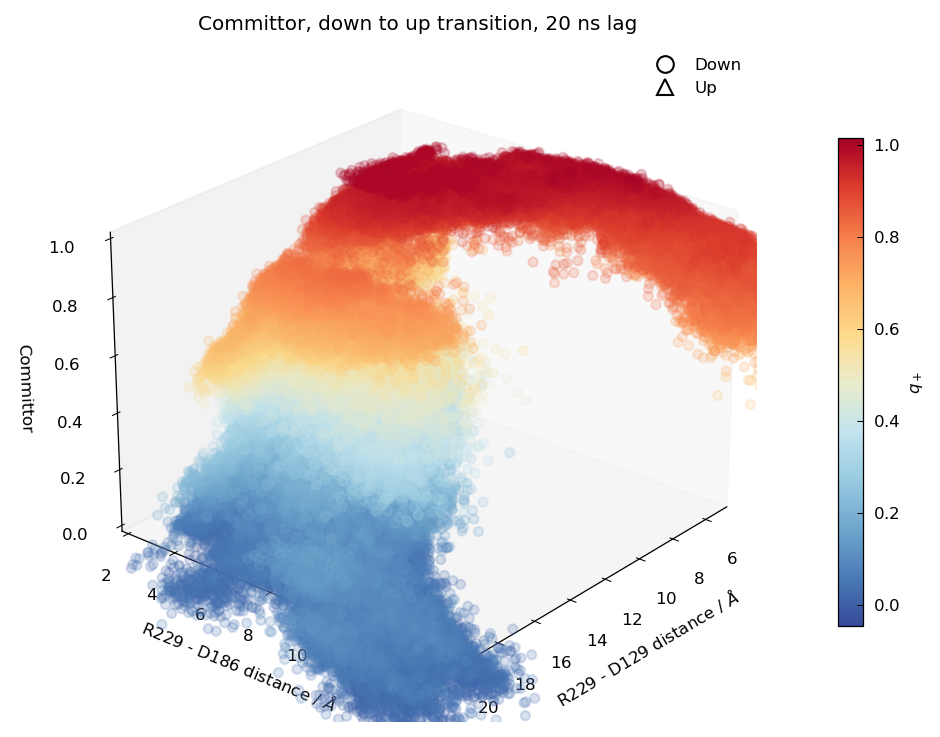

In [50]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection='3d')

h = ax.scatter(sb_arr[inds, sb_ids[1]] * 10, 
    sb_arr[inds, sb_ids[3]] * 10, 
    q[inds], 
    c=q[inds], 
    cmap=cm_div, 
    alpha=0.2)
ax.set_xlabel(f"{sb_labels[sb_ids[1] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[3] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([5, 20])
ax.set_ylim([2, 15])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)
cbar.set_label('$q_+$', rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

# ax.plot(feat2_models[1, sb_ids[1]] * 10, feat2_models[1, sb_ids[3]] * 10, 0, 
#         'o', mec='k', mfc='w', ms=8)
# ax.plot(feat2_models[2, sb_ids[1]] * 10, feat2_models[2, sb_ids[3]] * 10, 1, 
#         '^', mec='k', mfc='w', ms=8)
# ax.legend(['Down', 'Up'], loc='upper right')

ax.view_init(azim=40, elev=25)

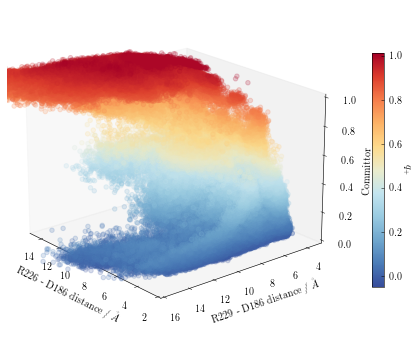

In [68]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection='3d')

h = ax.scatter(sb_arr[inds, sb_ids[2]] * 10, 
    sb_arr[inds, sb_ids[3]] * 10, 
    q[inds], 
    c=q[inds], 
    cmap=cm_div, 
    alpha=0.2)
ax.set_xlabel(f"{sb_labels[sb_ids[2] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[3] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([2, 15])
ax.set_ylim([3, 16])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)
cbar.set_label('$q_+$', rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

# ax.plot(feat2_models[1, sb_ids[1]] * 10, feat2_models[1, sb_ids[3]] * 10, 0, 
#         'o', mec='k', mfc='w', ms=8)
# ax.plot(feat2_models[2, sb_ids[1]] * 10, feat2_models[2, sb_ids[3]] * 10, 1, 
#         '^', mec='k', mfc='w', ms=8)
# ax.legend(['Down', 'Up'], loc='upper right')

ax.view_init(azim=140, elev=20)

In [44]:
q.shape

(3729000,)

In [45]:
# extract points which are between 0.45 and 0.55 committor
q = np.concatenate(q_downup[5])
q_ts_inds = ((q < 0.55) & (q > 0.45)).nonzero()[0]
q_ts = q[q_ts_inds]

In [46]:
sb_ts = sb_arr[q_ts_inds]

In [47]:
len(q_ts)

116807

In [1]:
f = plt.figure()
ax = plt.gca()
h = ax.scatter(sb_ts[..., sb_ids[0]], sb_ts[..., sb_ids[2]], c=q_ts, alpha=0.5, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

NameError: name 'plt' is not defined

[None]

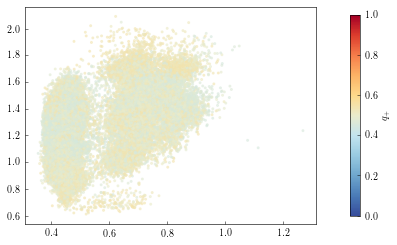

In [59]:
f = plt.figure()
ax = plt.gca()
h = ax.scatter(sb_ts[..., sb_ids[0]], sb_ts[..., sb_ids[1]], c=q_ts, alpha=0.5, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

[None]

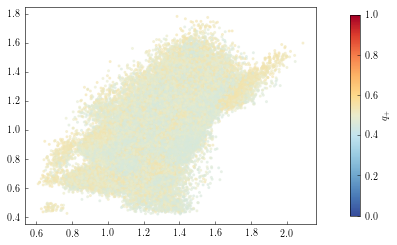

In [60]:
f = plt.figure()
ax = plt.gca()
h = ax.scatter(sb_ts[..., sb_ids[1]], sb_ts[..., sb_ids[2]], c=q_ts, alpha=0.5, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

[None]

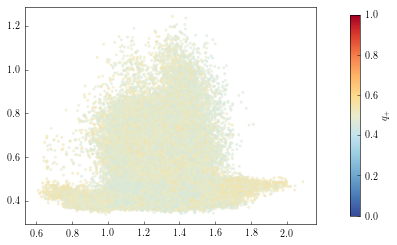

In [61]:
f = plt.figure()
ax = plt.gca()
h = ax.scatter(sb_ts[..., sb_ids[1]], sb_ts[..., sb_ids[3]], c=q_ts, alpha=0.5, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

[None]

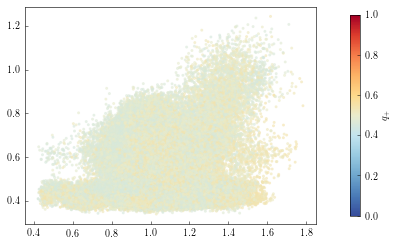

In [63]:
f = plt.figure()
ax = plt.gca()
h = ax.scatter(sb_ts[..., sb_ids[2]], sb_ts[..., sb_ids[3]], c=q_ts, alpha=0.5, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

[None]

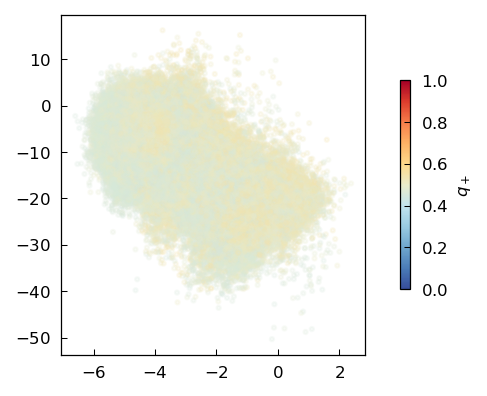

In [45]:
f = plt.figure()
ax = plt.gca()
plt.scatter(cv_arr[q_ts_inds, 0], cv_arr[q_ts_inds, 1], c=q_ts, alpha=0.2, cmap=cm_div, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label='$q_+$')
cbar.solids.set(alpha=1)

In [64]:
close_ids = util.find_closest_points((0.8, 1.3), sb_ts[:, [42, 47]], n=10)

In [65]:
close_ids

array([ 1481, 95125, 33262, 32645, 76556, 46310, 76673,  1705, 46614,
       46461])

In [66]:
q_ts_inds[close_ids]

array([ 225649, 3360122, 2627833, 2624493, 3138995, 2802394, 3139307,
        225952, 2803178, 2802945])

In [48]:
close_ids = util.find_closest_points((0.8, 1.3), sb_ts[:, [42, 47]], n=20)
for i in q_ts_inds[close_ids]:
    print(i)
#     print(sb_arr[i, [42, 27]])
    if i < 3000000:
        print(util.anton_frame(i))
    else:
        x = i - 3000000
        print(f"{traj_files[x // 3000]}, {x % 3000}")

225649
(22, 5649)
3360122
../../unbiased/101/civsd-3.nc, 122
2627833
(216, 7833)
2624493
(216, 4493)
3138995
../../unbiased/129/civsd.nc, 995
2802394
(247, 2394)
3139307
../../unbiased/129/civsd.nc, 1307
225952
(22, 5952)
2803178
(247, 3178)
2802945
(247, 2945)
2626699
(216, 6699)
2804110
(247, 4110)
3093141
../../unbiased/114/civsd.nc, 141
3138917
../../unbiased/129/civsd.nc, 917
2624495
(216, 4495)
3423328
../../unbiased/101/civsd-4.nc, 328
3054713
../../unbiased/101/civsd.nc, 713
3423009
../../unbiased/101/civsd-4.nc, 9
3093146
../../unbiased/114/civsd.nc, 146
225729
(22, 5729)


Comments: some expanded structures

In [49]:
close_ids = util.find_closest_points((0.8, 0.5), sb_ts[:, [42, 47]], n=20)
for i in q_ts_inds[close_ids]:
    print(i)
#     print(sb_arr[i, [0, 2]])
    if i < 3000000:
        print(util.anton_frame(i))
    else:
        x = i - 3000000
        print(f"{traj_files[x // 3000]}, {x % 3000}")

3060020
../../unbiased/103/civsd.nc, 20
2829783
(249, 9783)
2826581
(249, 6581)
2826425
(249, 6425)
2748225
(235, 8225)
2581746
(204, 1746)
3429041
../../unbiased/103/civsd-4.nc, 41
2748153
(235, 8153)
3060018
../../unbiased/103/civsd.nc, 18
2748195
(235, 8195)
2824787
(249, 4787)
2743811
(235, 3811)
2826517
(249, 6517)
2826423
(249, 6423)
2820327
(249, 327)
2825801
(249, 5801)
2590806
(208, 806)
3303010
../../unbiased/103/civsd-2.nc, 10
2748287
(235, 8287)
3300043
../../unbiased/102/civsd-2.nc, 43


Comments: R226 bent downwards so that guanidinium is bent below hydrophobic plug

In [50]:
close_ids = util.find_closest_points((0.45, 0.8), sb_ts[:, [42, 47]], n=20)
for i in q_ts_inds[close_ids]:
    print(i)
    if i < 3000000:
        print(util.anton_frame(i))
    else:
        x = i - 3000000
        print(f"{traj_files[x // 3000]}, {x % 3000}")

2536092
(195, 6092)
3700941
../../unbiased/289/civsd-3.nc, 1941
269128
(26, 9128)
2534787
(195, 4787)
266902
(26, 6902)
269729
(26, 9729)
3386358
../../unbiased/088/civsd-4.nc, 2358
268222
(26, 8222)
3177499
../../unbiased/142/civsd.nc, 499
2663384
(220, 3384)
2937224
(280, 7224)
268843
(26, 8843)
267194
(26, 7194)
3613817
../../unbiased/288/civsd-1.nc, 1817
3386226
../../unbiased/088/civsd-4.nc, 2226
2533281
(195, 3281)
3190252
../../unbiased/146/civsd.nc, 1252
2931559
(280, 1559)
2662629
(220, 2629)
3613652
../../unbiased/288/civsd-1.nc, 1652


Comments: S4 helix is very far down, the R226 is sticking upwards; 280/7224 is only unusual one where R226 sidehcain is lodged into hydrophobic plug

In [51]:
close_ids = util.find_closest_points((0.45, 1.2), sb_ts[:, [42, 47]], n=20)
for i in q_ts_inds[close_ids]:
    print(i)
    if i < 3000000:
        print(util.anton_frame(i))
    else:
        x = i - 3000000
        print(f"{traj_files[x // 3000]}, {x % 3000}")

2805248
(247, 5248)
1255791
(125, 5791)
2915959
(264, 5959)
2917154
(264, 7154)
3167904
../../unbiased/138/civsd.nc, 2904
2944392
(281, 4392)
1251691
(125, 1691)
2943420
(281, 3420)
2913970
(264, 3970)
2635372
(217, 5372)
3095649
../../unbiased/114/civsd.nc, 2649
2913305
(264, 3305)
2913939
(264, 3939)
2519836
(193, 9836)
3511220
../../unbiased/274/civsd-2.nc, 1220
2634480
(217, 4480)
2943312
(281, 3312)
2003171
(181, 13171)
2943117
(281, 3117)
3568696
../../unbiased/274/civsd-3.nc, 1696


Comments: seems quite similar to previous ones, but perhaps R226 is pointing further up, and also S3 might be pulled down and away slightly

*structures saved in `qhalf_sb02.vmd`*